<h3><b>VIDEO RATINGS ANALYSIS</b></h3>
<p>Takes the video ratings scores for the three outcomes (fear, disgust and points) at two timepoints and assesses the success of the video-matching procedure (which takes place after the video ratings task). Looking for differences in rating between fear and disgust videos</p>
<p>Carries out the checks using mixed effects models, as specified in the analysis plan (as well as detailing what is expected from these checks)</p>
<br>
<p>Also tests for differences between how participants rated experiencing losing points on the points task and their initial ratings of the fear and disgust videos. Again, to validate the task design. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import std, mean, sqrt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [2]:
chosen_stim_df = pd.read_csv("csvs/chosen_stim_excluded.csv")
chosen_stim_df.drop('Unnamed: 0', axis="columns", inplace=True)

In [3]:
#create long form df which allows for this
long_chosen_stim_df=pd.DataFrame()
for i in chosen_stim_df.index:
    row=chosen_stim_df.loc[i]
    #timepoint=['unpleasan']
    timepoint_1=pd.DataFrame({
    'participant_no': [row.participant_no],
    'age': [row.prolific_age],
    'sex': [row. prolific_sex],
    'Vid': [str(row['Vid'])],
    'trial_type': [row.trial_type],
    'Valence': [row.unpleasant_1],
    'Arousal': [row.arousing_1],
    'Fear': [row.frightening_1],
    'Disgust': [row.disgusting_1],
    'Timepoint': 1.0
    })
    timepoint_2=pd.DataFrame({
        'participant_no': [row.participant_no],
        'age': [row.prolific_age],
        'sex': [row. prolific_sex],
        'Vid': [str(row['Vid'])],
        'trial_type': [row.trial_type],
        'Valence': [row.unpleasant_2],
        'Arousal': [row.arousing_2],
        'Fear': [row.frightening_2],
        'Disgust': [row.disgusting_2],
        'Timepoint': 2.0
    })
    long_chosen_stim_df_row=pd.concat([timepoint_1, timepoint_2])
    long_chosen_stim_df=pd.concat([long_chosen_stim_df_row, long_chosen_stim_df])
    long_chosen_stim_df=long_chosen_stim_df[long_chosen_stim_df.trial_type!="points"]

<h3><b>1. Analysing the emotional videos (Fear and disgust) across timepoints</b></h3>
<p> Doing this using 4 mixed effects models - testing effect of timepoint and stimulus type on ratings </p>
<p>List of models to run:
<li> A) 'Valence ~ trial_type*Timepoint'
<li> B) 'Arousal ~ trial_type*Timepoint'
<li> C) 'Disgust ~ trial_type*Timepoint'
<li> D) 'Fear ~ trial_type*Timepoint'
<br>
<p>NB this is only looking at the videos selected to be used in the reversal learning task (1 disgust and 1 fear for each participant)

<p><b>MODEL A: VALENCE ~ TRIAL_TYPE*TIMEPOINT</b></p>

In [4]:
##Test the fit of different variations of model A
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)

formula = 'Valence ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

     randslope  vid_randint_randslope  basic_model  vid_randint
0  5450.343298            5457.558538  5467.191008  5566.195514


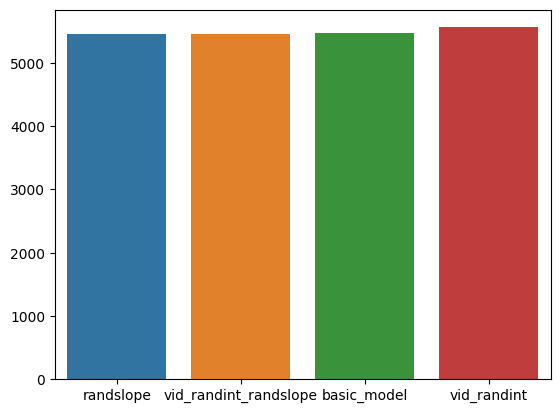

In [5]:
#test which random effects to include
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, randslope is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0   5450.343298     5453.27167    5456.832328        5459.830669


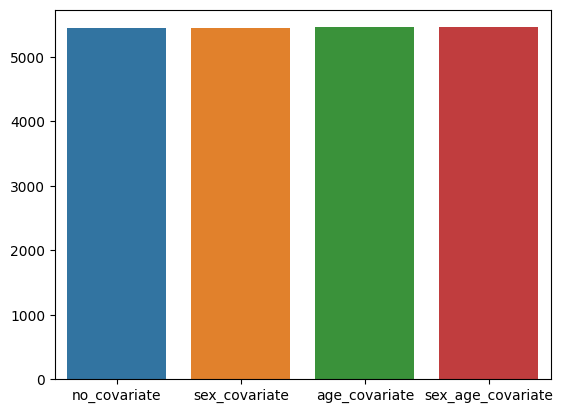

In [6]:
##test which covariates to add -- Using the random effects which were best above
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [7]:
#Hypothesis test using this model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    Valence   
No. Observations:    1360       Method:                ML        
No. Groups:          340        Scale:                 1.8645    
Min. group size:     4          Log-Likelihood:        -2696.3107
Max. group size:     4          Converged:             Yes       
Mean group size:     4.0                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.318    0.381 16.590 0.000  5.571  7.064
trial_type             -0.488    0.240 -2.033 0.042 -0.959 -0.018
Timepoint               0.224    0.234  0.955 0.340 -0.235  0.683
trial_type:Timepoint   -0.329    0.148 -2.224 0.026 -0.620 -0.039
Group Var               2.692    0.506                           
Group x trial_type Cov -0.975    0.279                           
trial_type Var          0.959    0.194                           
=================================================================

"""

<p><b>MODEL B: AROUSAL ~ TRIAL_TYPE*TIMEPOINT</b></p>

In [8]:
##mixed effects model Arousal (model B)
formula = 'Arousal ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint            randslope vid_randint_randslope
0  5051.633916  5273.516342  CONVERGENCE WARNING   CONVERGENCE WARNING


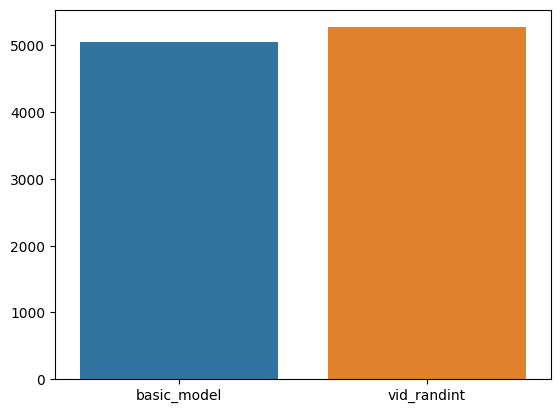

In [11]:
#select best random effects structure
##commented out models did not converge
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False) CONVERGENCE WARNING
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False) #CONVERGENCE WARNING

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, basic model is best

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   5051.633916    5052.127046    5054.846418        5055.478394


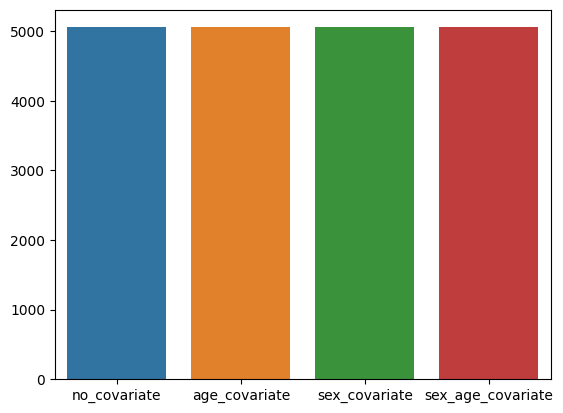

In [12]:
##test which covariates to add -- Using the random effects which were best above (basic model)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, no covariate is the best

In [13]:
#Hypothesis test using this model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   Arousal   
No. Observations:    1360      Method:               ML        
No. Groups:          340       Scale:                1.5506    
Min. group size:     4         Log-Likelihood:       -2504.1712
Max. group size:     4         Converged:            Yes       
Mean group size:     4.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.568    0.344 13.260 0.000  3.892  5.243
trial_type            0.594    0.214  2.782 0.005  0.176  1.013
Timepoint            -0.165    0.214 -0.771 0.441 -0.583  0.254
trial_type:Timepoint -0.215    0.135 -1.590 0.112 -0.479  0.050
Group Var             1.580    0.140                           
===============================================================

"""

<p><b>MODEL C: DISGUST ~ TRIAL_TYPE*TIMEPOINT</b></p>

In [14]:
##mixed effects model Disgust (model C)
formula = 'Disgust ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

     randslope  vid_randint  vid_randint_randslope  basic_model
0  5166.185475    5173.3827            5173.400714  5293.322268


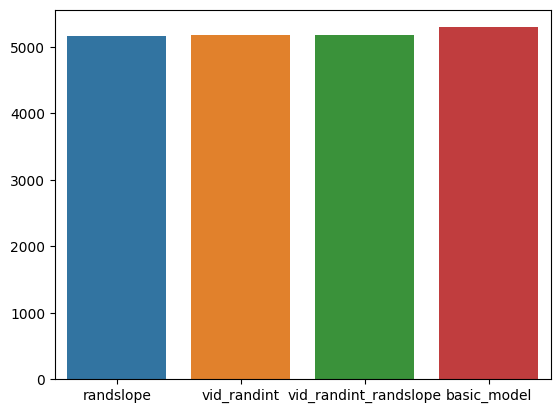

In [15]:
#select best random effects structure
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##randslope is best fitting

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   5166.185475    5171.280346    5172.462865        5177.585387


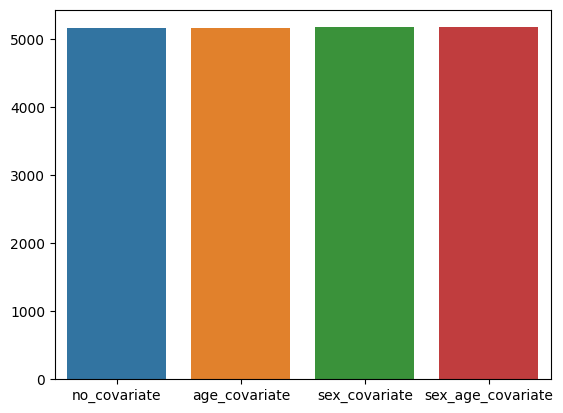

In [16]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [17]:
#Hypothesis test using this model 
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    Disgust   
No. Observations:     1360       Method:                ML        
No. Groups:           340        Scale:                 1.3046    
Min. group size:      4          Log-Likelihood:        -2554.2318
Max. group size:      4          Converged:             Yes       
Mean group size:      4.0                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              12.262    0.343  35.743 0.000 11.589 12.934
trial_type             -5.762    0.214 -26.953 0.000 -6.181 -5.343
Timepoint              -0.888    0.196  -4.535 0.000 -1.272 -0.504
trial_type:Timepoint    0.582    0.124   4.701 0.000  0.340  0.825
Group Var               7.398    0.877                            
Group x trial_type Cov -3.932    0.498                            
trial_type Var          2.492    0.312                            
==================================================================

"""

<p><b>MODEL D: FEAR ~ TRIAL_TYPE*TIMEPOINT</b></p>

In [18]:
##mixed effects model Fear (model D)
formula = 'Fear ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

     randslope  vid_randint_randslope  vid_randint  basic_model
0  5497.603288            5504.818527  5540.669101   5648.19592


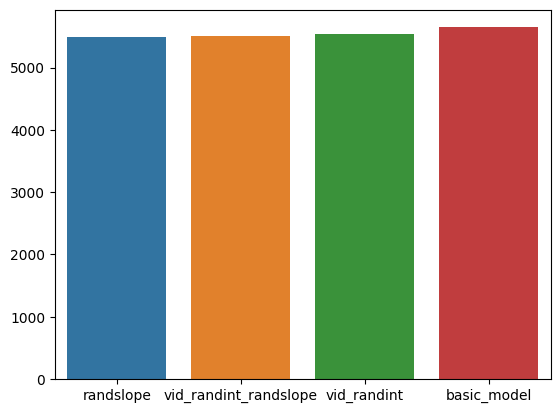

In [19]:
#select best random effects structure
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##randslope is best

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   5497.603288    5498.456511    5504.703735        5505.549418


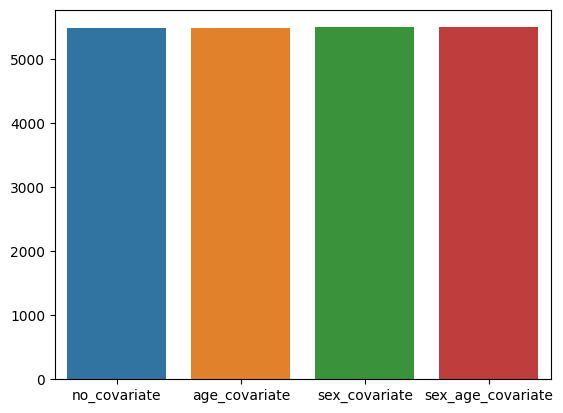

In [20]:
##test which covariates to add -- Using the random effects which were best above (rand slope)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [21]:
#Hypothesis test using this model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    Fear      
No. Observations:     1360       Method:                ML        
No. Groups:           340        Scale:                 1.4539    
Min. group size:      4          Log-Likelihood:        -2719.9407
Max. group size:      4          Converged:             Yes       
Mean group size:      4.0                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              -4.576    0.366 -12.511 0.000 -5.293 -3.860
trial_type              5.391    0.228  23.613 0.000  4.944  5.839
Timepoint               1.671    0.207   8.079 0.000  1.265  2.076
trial_type:Timepoint   -1.124    0.131  -8.591 0.000 -1.380 -0.867
Group Var               9.150    0.996                            
Group x trial_type Cov -4.671    0.557                            
trial_type Var          3.185    0.361                            
==================================================================

"""

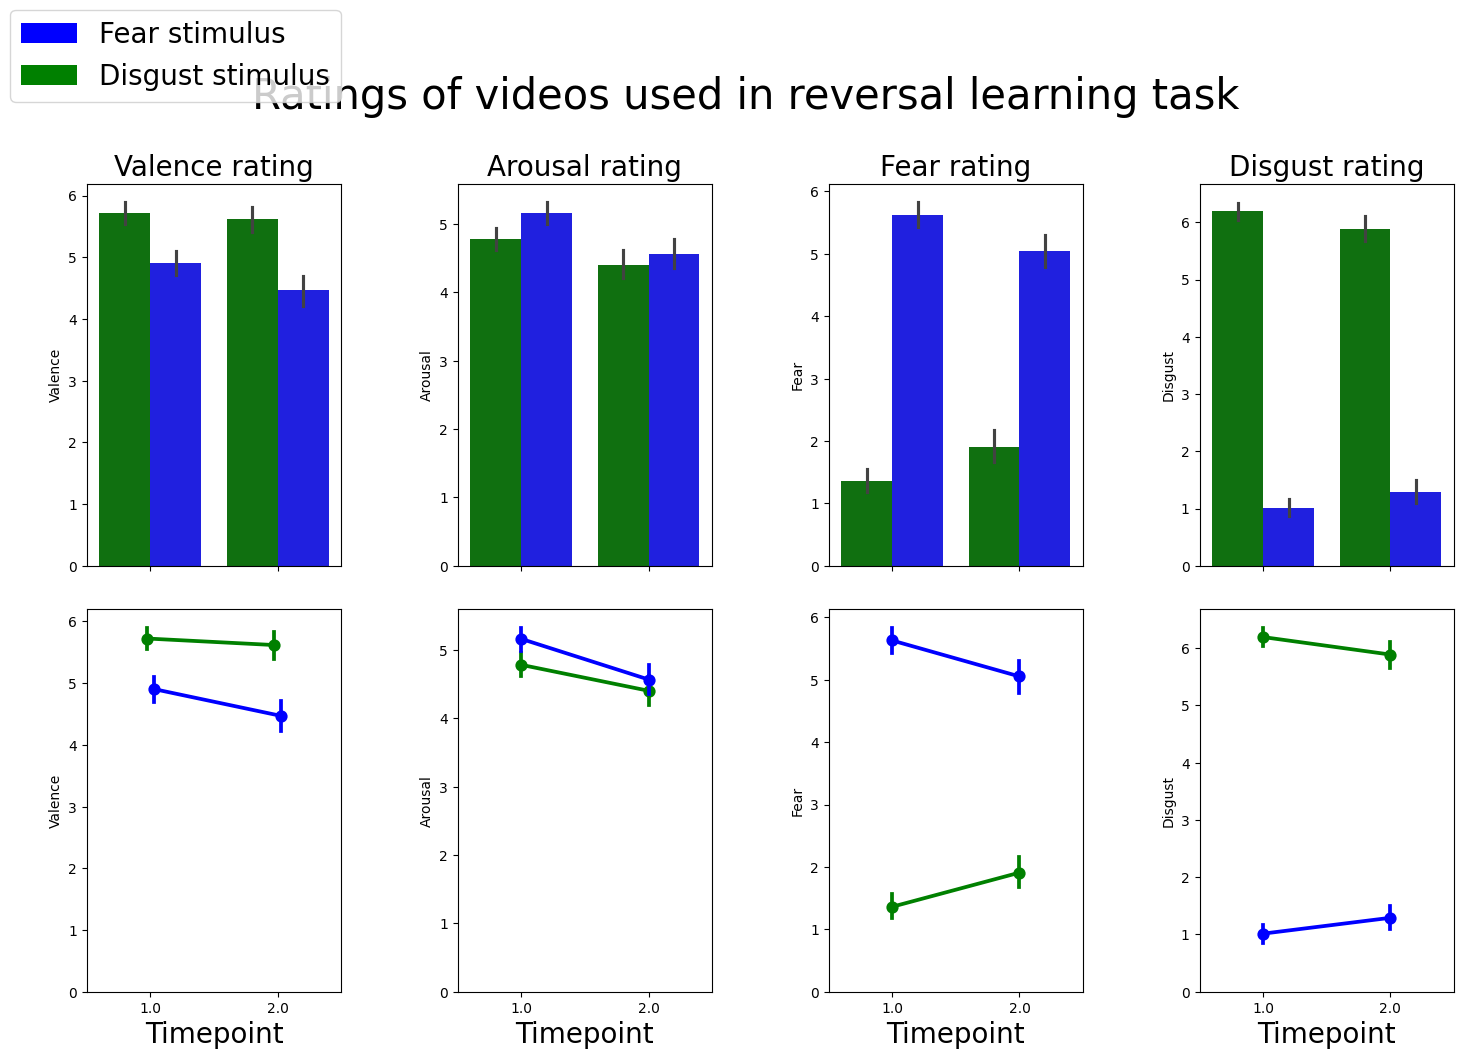

In [23]:
#example plot for this data
fig, axes = plt.subplots(2,4, sharex='col', sharey='col')
title="Ratings of videos used in reversal learning task"
plt.suptitle(title, fontsize=30)
fig.tight_layout(pad=0.5)
fig.set_size_inches(15, 10)

palette = {'fear': 'blue',
            'disgust': 'green'}
#sns.stripplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
sns.barplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', fill=True, palette=palette, linewidth=1)
axes[0,0].get_legend().set_visible(False)
axes[0,0].set_title("Valence rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
axes[1,0].get_legend().set_visible(False)
axes[1,0].xaxis.get_label().set_fontsize(20)

#sns.stripplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=True, palette=palette)
sns.barplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', fill=True, palette=palette, linewidth=1)
axes[0,1].get_legend().set_visible(False)
axes[0,1].set_title("Arousal rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=False, palette=palette)
axes[1,1].get_legend().set_visible(False)
axes[1,1].xaxis.get_label().set_fontsize(20)

#sns.stripplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', dodge=True, palette=palette)
sns.barplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', fill=True, palette=palette, linewidth=1)
axes[0,2].get_legend().set_visible(False)
axes[0,2].set_title("Fear rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,2], x='Timepoint', y='Fear', hue='trial_type', dodge=False, palette=palette)
axes[1,2].get_legend().set_visible(False)
axes[1,2].xaxis.get_label().set_fontsize(20)

#sns.stripplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=True, palette=palette)
sns.barplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', fill=True, palette=palette, linewidth=1)
axes[0,3].get_legend().set_visible(False)
axes[0,3].set_title("Disgust rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=False, palette=palette)
axes[1,3].get_legend().set_visible(False)
axes[1,3].xaxis.get_label().set_fontsize(20)

plt.figlegend(loc='center left', bbox_to_anchor=(0,1),  handles=[mpatches.Patch(facecolor='blue'), mpatches.Patch(facecolor='green')], labels=['Fear stimulus', 'Disgust stimulus'], prop={'size':20})
plt.show()

<h3><b>2. Check points ratings</b></h3>
<p>Aim: check whether points block differs from other blocks in terms of ratings (at T1) - a sanity check</p>
<p>List of models to run: </p>
<li> E) 'Valence ~ trial_type'
<li> F) 'Arousal ~ trial_type'
<li> G) 'Disgust~ trial_type'
<li> H) 'Fear ~ trial_type'

<p><b>MODEL E: VALENCE ~ TRIAL_TYPE</b></p>

In [53]:
#Model E
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1', 'Vid', 'prolific_age', 'prolific_sex']]
data.replace(['points'],['apoints'], inplace=True) ##makes comparison condition points

formula = 'unpleasant_1 ~ trial_type'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model          vid_randint           randslope vid_randint_randslope
0  3839.747029  CONVERGENCE WARNING  CONVERENCE WARNING   CONVERGENCE WARNING


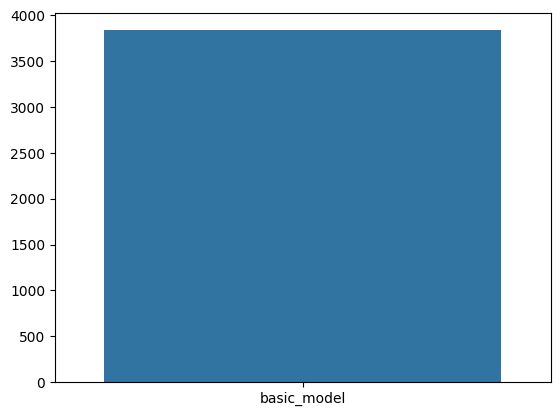

In [57]:
#test random effects
#commented out models did not converge 

#vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False) CONVERGENCE WARNING
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False) ##CONVERGENCE WARNING
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': ['CONVERGENCE WARNING'], 
                    'randslope': ['CONVERENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, basic model is best

   sex_covariate  no_covariate  sex_age_covariate  age_covariate
0    3839.001589   3839.747029        3845.388568    3846.209997


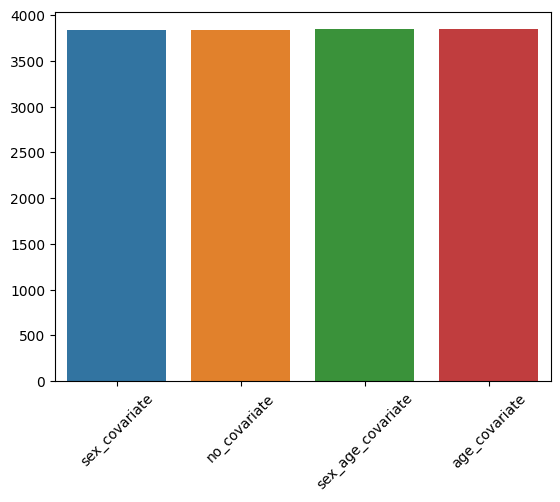

In [58]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, the sex covariate is best

In [59]:
#Hypothesis test using this model
sex_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:              MixedLM   Dependent Variable:   unpleasant_1
No. Observations:   938       Method:               ML          
No. Groups:         340       Scale:                2.4872      
Min. group size:    2         Log-Likelihood:       -1898.9695  
Max. group size:    3         Converged:            Yes         
Mean group size:    2.8                                         
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              4.907    0.139 35.312 0.000  4.634  5.179
trial_type[T.disgust]  1.025    0.132  7.742 0.000  0.765  1.284
trial_type[T.fear]     0.207    0.132  1.565 0.118 -0.052  0.467
prolific_sex[T.Male]  -0.434    0.157 -2.768 0.006 -0.741 -0.127
Group Var              1.169    0.127                           
================================================================

"""

In [60]:
#And run no-covariate model for comparison
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM  Dependent Variable:  unpleasant_1
No. Observations:    938      Method:              ML          
No. Groups:          340      Scale:               2.4893      
Min. group size:     2        Log-Likelihood:      -1902.7641  
Max. group size:     3        Converged:           Yes         
Mean group size:     2.8                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.699    0.117 40.012 0.000  4.469  4.929
trial_type[T.disgust] 1.025    0.132  7.736 0.000  0.765  1.284
trial_type[T.fear]    0.207    0.132  1.563 0.118 -0.053  0.467
Group Var             1.212    0.130                           
===============================================================

"""

<p><b>MODEL F: AROUSAL ~ TRIAL_TYPE</b></p>

In [62]:
#Model F
formula = 'arousing_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint            randslope vid_randint_randslope
0  3595.880903  3699.044985  CONVERGENCE WARNING   CONVERGENCE WARNING


u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


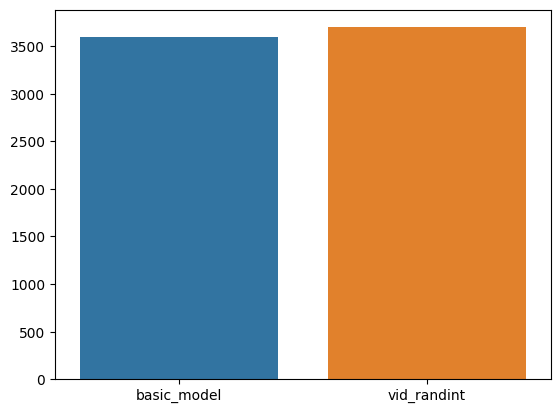

In [65]:
#test random effects
#commented out models did not converge

#vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False) CONVERGENCE WARNING
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False) CONVERGENCE WARNING

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': ['CONVERGENCE WARNING'], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, basic model

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   3595.880903     3599.32339    3600.335451        3603.862585


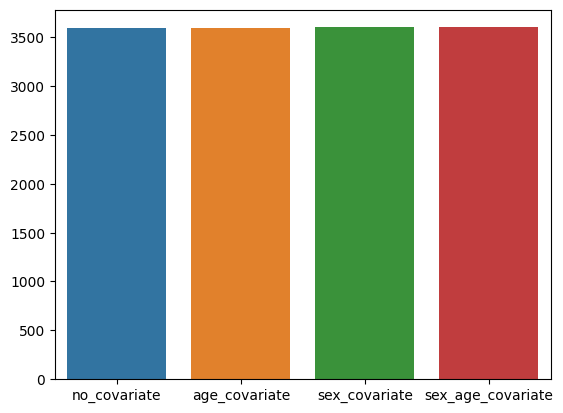

In [66]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, no covariate

In [67]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM   Dependent Variable:   arousing_1
No. Observations:     938       Method:               ML        
No. Groups:           340       Scale:                1.8470    
Min. group size:      2         Log-Likelihood:       -1780.8311
Max. group size:      3         Converged:            Yes       
Mean group size:      2.8                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              4.835    0.104 46.511 0.000  4.631  5.039
trial_type[T.disgust] -0.053    0.114 -0.460 0.645 -0.277  0.171
trial_type[T.fear]     0.327    0.114  2.858 0.004  0.103  0.551
Group Var              1.077    0.125                           
================================================================

"""

<p><b>MODEL G: DISGUST ~ TRIAL_TYPE</b></p>

In [68]:
##Model G
formula = 'disgusting_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint            randslope vid_randint_randslope
0   3714.95498  3754.369706  CONVERGENCE WARNING   CONVERGENCE WARNING


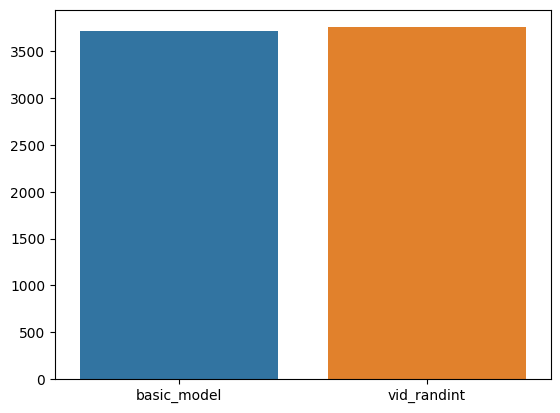

In [73]:
#test random effects
##commented out models did not converge

vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False) 
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, randslope is best

   age_covariate  no_covariate  sex_age_covariate  sex_covariate
0    3714.694016    3714.95498        3720.082483    3720.260396


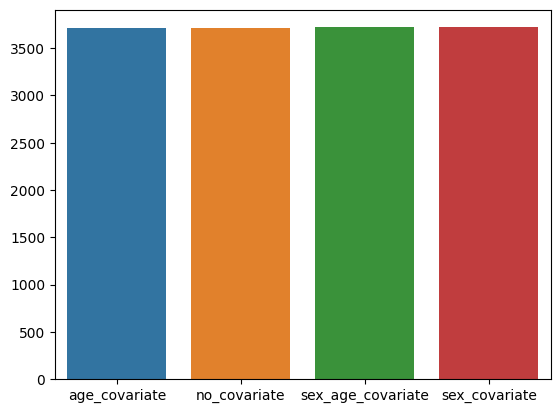

In [74]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is best

In [75]:
#Hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:              MixedLM   Dependent Variable:   disgusting_1
No. Observations:   938       Method:               ML          
No. Groups:         340       Scale:                2.4082      
Min. group size:    2         Log-Likelihood:       -1836.8158  
Max. group size:    3         Converged:            Yes         
Mean group size:    2.8                                         
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.235    0.230  9.697 0.000  1.783  2.686
trial_type[T.disgust]  4.494    0.130 34.644 0.000  4.240  4.748
trial_type[T.fear]    -0.685    0.130 -5.284 0.000 -0.940 -0.431
prolific_age          -0.012    0.004 -2.679 0.007 -0.021 -0.003
Group Var              0.645    0.092                           
================================================================

"""

In [76]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:              MixedLM   Dependent Variable:   disgusting_1
No. Observations:   938       Method:               ML          
No. Groups:         340       Scale:                2.4094      
Min. group size:    2         Log-Likelihood:       -1840.3681  
Max. group size:    3         Converged:            Yes         
Mean group size:    2.8                                         
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.689    0.108 15.597 0.000  1.477  1.902
trial_type[T.disgust]  4.505    0.130 34.722 0.000  4.250  4.759
trial_type[T.fear]    -0.675    0.130 -5.200 0.000 -0.929 -0.420
Group Var              0.675    0.094                           
================================================================

"""

<p><b>MODEL H: FEAR ~ TRIAL_TYPE</b></p>

In [77]:
#Model H
formula = 'frightening_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model          vid_randint    randslope  vid_randint_randslope
0  3888.757755  CONVERGENCE WARNING  3895.347824            3902.191574


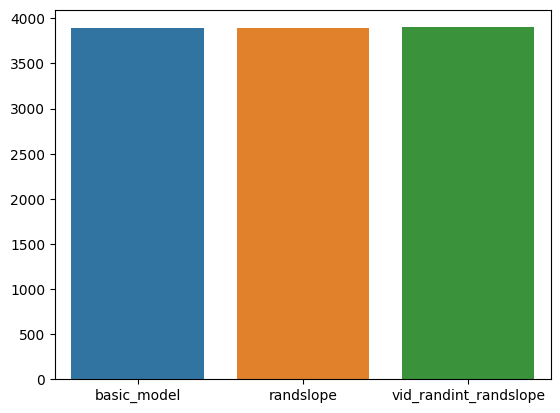

In [79]:
#test random effects
#commented out models did not converge

#vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False) CONVERGENCE WARNING
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': ['CONVERGENCE WARNING'], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, basic model is best

   age_covariate  sex_age_covariate  no_covariate  sex_covariate
0    3881.494492        3888.145399   3888.757755    3895.469264


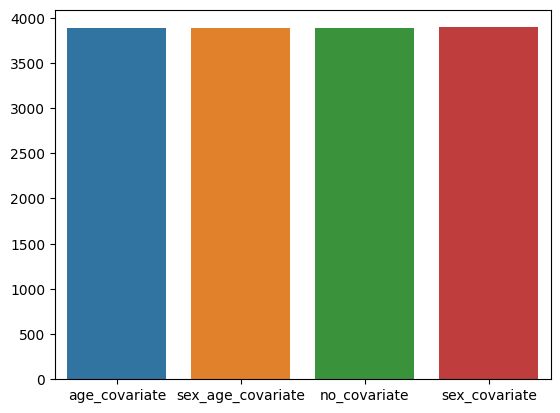

In [80]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is best

In [81]:
#Hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM  Dependent Variable:  frightening_1
No. Observations:    938      Method:              ML           
No. Groups:          340      Scale:               2.6363       
Min. group size:     2        Log-Likelihood:      -1920.2160   
Max. group size:     3        Converged:           Yes          
Mean group size:     2.8                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.656    0.268  9.916 0.000  2.131  3.181
trial_type[T.disgust] -0.398    0.136 -2.923 0.003 -0.665 -0.131
trial_type[T.fear]     3.869    0.136 28.398 0.000  3.602  4.136
prolific_age          -0.020    0.005 -3.800 0.000 -0.030 -0.010
Group Var              1.162    0.125                           
================================================================

"""

In [82]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM  Dependent Variable:  frightening_1
No. Observations:    938      Method:              ML           
No. Groups:          340      Scale:               2.6332       
Min. group size:     2        Log-Likelihood:      -1927.2695   
Max. group size:     3        Converged:           Yes          
Mean group size:     2.8                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.745    0.120 14.490 0.000  1.509  1.982
trial_type[T.disgust] -0.384    0.136 -2.817 0.005 -0.651 -0.117
trial_type[T.fear]     3.884    0.136 28.513 0.000  3.617  4.151
Group Var              1.258    0.131                           
================================================================

"""

Text(313.26767676767673, 0.5, 'Fear')

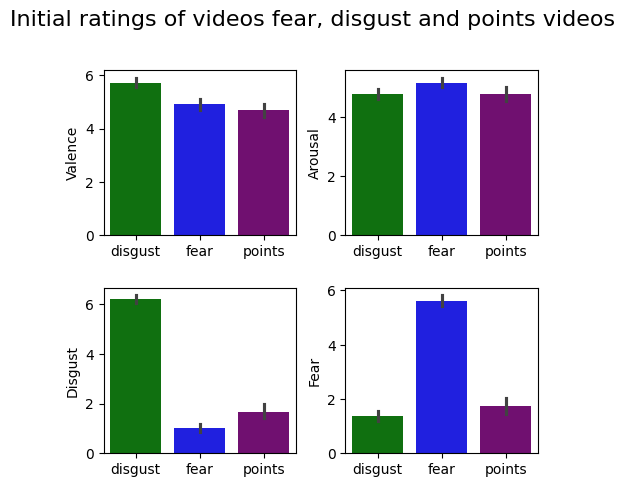

In [52]:
#example plot for this data
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']].sort_values('trial_type')
fig, axes = plt.subplots(2,2)
title="Initial ratings of videos fear, disgust and points videos"
plt.suptitle(title, fontsize=16)
fig.tight_layout(pad=1.5)
fig.set_size_inches(5, 5)

order=['fear', 'disgust', 'points']
palette = {'fear': 'blue',
            'disgust': 'green',
            'points': 'purple'}
sns.barplot(data=data, ax=axes[0,0],   x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, fill=True, linewidth=1, hue_order=order)
#sns.stripplot(data=data, ax=axes[0,0],  x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Valence')

sns.barplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, fill=True, linewidth=1, hue_order=order)
#sns.stripplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Arousal')

sns.barplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, fill=True, linewidth=1, hue_order=order)
#sns.stripplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Disgust')

sns.barplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type', y='frightening_1', palette=palette, legend=False, fill=True, linewidth=1, hue_order=order)
#sns.stripplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type',  y='frightening_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Fear')

<h3>Conclusions</h3>
<p>Results from these models tells us:</p>
<li>The stimulus selection procedure was unable to produce perfectly matched fear and disgust videos (with disgust videos being marginally more negatively valenced and fear videos being more arousing).
<li>There was a difference in habituation between fear and disgust (fear habituated less than disgust), which is in-line with previous literature.
<li>Fear and disgust videos reliably induced the emotions of fear and disgust (with fear videos producing much higher fear ratings and vice versa).
<li>The 'loss' feedback type (from the points conditions) was more similar to the emotional learning conditions than expected. It did not differ from fear in terms of valence and did not differ from disgust in terms of arousal.
<li>The 'loss' feedback type was, however, very different to the emotional conditions in terms of fear and disgust ratings. 
<p></p>